In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [5]:
df_combined = pd.read_csv('SP500.csv', parse_dates=[0])

In [6]:
from datetime import datetime as dt
df_combined['Date'] = pd.to_datetime(df_combined.Date, format = '%m/%d/%Y',errors='coerce')
print(df_combined.shape)
df_combined.head()

(7362, 3)


,Date,SP,RSL
0,1992-12-10,434.64,231.929993
1,1992-12-11,433.73,231.520004
2,1992-12-14,432.84,231.070007
3,1992-12-15,432.57,230.860001
4,1992-12-16,431.52,230.169998


In [7]:
import scipy
from scipy import signal
detrended_SP = scipy.signal.detrend(df_combined['Close'])
type(detrended_SP)

numpy.ndarray

In [8]:
df_detrended_SP = pd.DataFrame(detrended_SP, columns = ['Close'])

df_detrended_SP['Date'] = pd.to_datetime(df_combined.Date, format='%m/%d/%Y',errors='coerce')
df_detrended_SP = df_detrended_SP[['Date', 'Close']]

print(df_detrended_SP.head)
print(df_detrended_SP.shape)

<bound method NDFrame.head of            Date           SP
0    1992-12-10   215.136458
1    1992-12-11   213.866083
2    1992-12-14   212.615708
3    1992-12-15   211.985332
4    1992-12-16   210.574957
...         ...          ...
7357 2022-02-28  1503.154166
7358 2022-03-01  1435.113790
7359 2022-03-02  1515.033415
7360 2022-03-03  1491.623040
7361 2022-03-04  1456.642664

[7362 rows x 2 columns]>
<bound method NDFrame.head of            Date         RSL
0    1992-12-10  139.758694
1    1992-12-11  139.143781
2    1992-12-14  138.488860
3    1992-12-15  138.073930
4    1992-12-16  137.179002
...         ...         ...
7357 2022-02-28  822.991209
7358 2022-03-01  785.296295
7359 2022-03-02  829.441224
7360 2022-03-03  812.036349
7361 2022-03-04  789.061405

[7362 rows x 2 columns]>
(7362, 2)


(7362, 2)

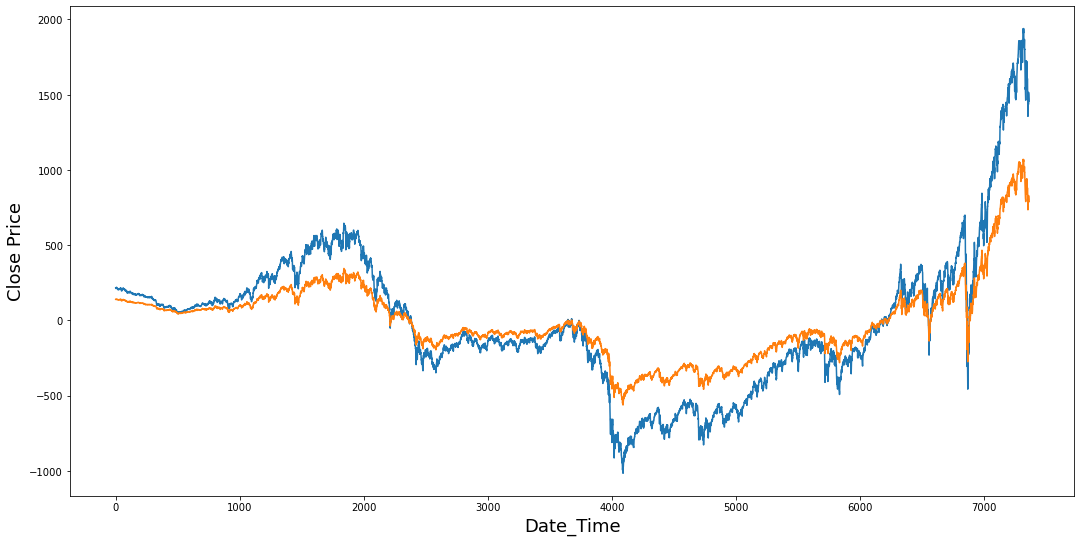

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df_combined.shape[0]),(df_detrended_SP['Close']))
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [10]:
# how long preceding sequence to consider for prediction
SEQ_LEN = 10        

# How far into the future we are making prediction(1 day in this case)
FUTURE_PERIOD = 1

RATIO_TO_PREDICT = "Close"

In [11]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

Split the data as last % for testing, the next last % for validation and remaining % for training the model

In [12]:
times = sorted(df_detrended_SP.index.values)  # get the times
last_33 = sorted(df_detrended_SP.index.values)[-int(0.33*len(times))] 
last_66 = sorted(df_detrended_SP.index.values)[-int(0.66*len(times))]

test_df_trended = df_detrended_SP[(df_detrended_SP.index >= last_33)]
test_df = scipy.signal.detrend(test_df_trended['Close'])
validation_df_trended = df_detrended_SP[(df_detrended_SP.index >= last_66) & (df_detrended_SP.index < last_33)] 
validation_df = scipy.signal.detrend(validation_df_trended['Close'])
train_df_trended = df_detrended_SP[(df_detrended_SP.index < last_66)]
train_df = scipy.signal.detrend(train_df_trended['Close'])

In [13]:
from collections import deque
import numpy as np
import random

In [14]:
train_ = train_df                                # to numpy array
valid_ = validation_df
test_ = test_df

In [15]:
type(train_)

numpy.ndarray

In [16]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (2504,)
valid shape (2429,)
test shape (2429,)


In [18]:
scaler = MinMaxScaler()

train_ = scaler.fit_transform(train_.reshape(-1,1))
valid_ = scaler.fit_transform(valid_.reshape(-1,1))
test_ = scaler.fit_transform(test_.reshape(-1,1))

In [24]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), ])                 
    return np.array(X), np.array(Y)

In [26]:
print(train_.shape)
print(test_.shape)
print(valid_.shape)

(2504, 1)
(2429, 1)
(2429, 1)


In [27]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

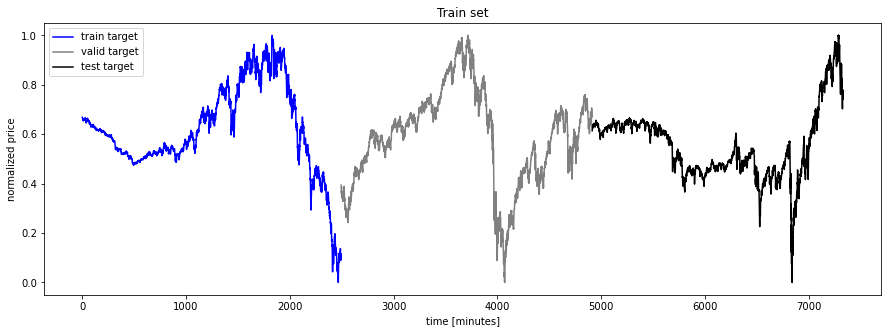

In [28]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# TRANSFORMER

In [30]:
EPOCHS = 200
BATCH_SIZE = None

import time

In [31]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization. i.e. applies a transformation that maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.

In [32]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape


In [33]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

In [34]:
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

In [35]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [36]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

Text(0.5, 0, 'Train Step')

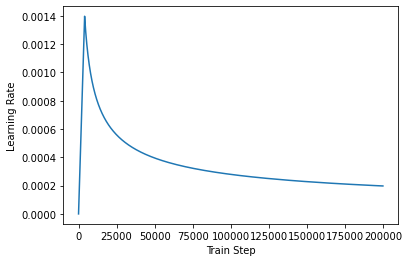

In [37]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [38]:
D_MODEL=100

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [39]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))                                 

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #for i in range(2):
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=4, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer)
    
    return model

In [40]:
multi_head = build_model()
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 10, 256)      133120      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 10, 128)     164352      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 10, 256)      32768       ['bidirectional_1[0][0]']    

# TRAINING

In [42]:
callback = EarlyStopping(patience = 20, min_delta= 0.0001)

In [43]:
type(X_train)

numpy.ndarray

In [44]:
history = multi_head.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid)
                        , callbacks=[callback])

Epoch 1/200
78/78 [==============================] - 17s 80ms/step - loss: 0.0308 - val_loss: 0.0429
Epoch 2/200
78/78 [==============================] - 4s 46ms/step - loss: 0.0081 - val_loss: 0.0218
Epoch 3/200
78/78 [==============================] - 4s 46ms/step - loss: 0.0029 - val_loss: 0.0216
Epoch 4/200
78/78 [==============================] - 4s 46ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 5/200
78/78 [==============================] - 4s 46ms/step - loss: 0.0013 - val_loss: 0.0110
Epoch 6/200
78/78 [==============================] - 4s 47ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/200
78/78 [==============================] - 4s 46ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 8/200
78/78 [==============================] - 4s 47ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 9/200
78/78 [==============================] - 4s 46ms/step - loss: 8.5861e-04 - val_loss: 9.9185e-04
Epoch 10/200
78/78 [==============================] - 4s 46ms/step - loss: 9.3200e-04 - val

In [45]:
multi_head.save_weights('multi_head.h5')

# TESTING

In [47]:
predicted_stock_price_multi_head = multi_head.predict(X_test)

predicted_stock_price_multi_head.shape

(2419, 1)

Stacking arrays in sequence vertically (row wise).

In [48]:
predicted_stock_price = np.vstack((np.full((10,1), np.nan), predicted_stock_price_multi_head))

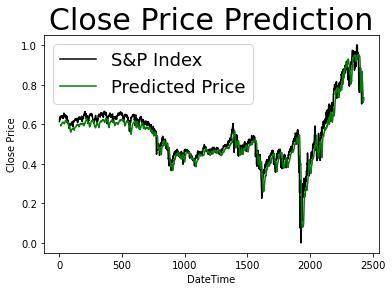

In [49]:
plt.plot(y_test, color = 'black', label = 'S&P Index')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
mse_mh = mean_squared_error(np.squeeze(y_test), np.squeeze(predicted_stock_price_multi_head))
print(mse_mh)

0.0007935857668468569
